# TME 1 - Arbres de décision, sélection de modèles

In [1]:
import numpy as np
import collections as cl
import pickle
from sklearn . tree import export_graphviz
from sklearn . tree import DecisionTreeClassifier as DTree
import pydotplus
from IPython.display import IFrame
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
import matplotlib.pyplot as plt
import time

## L'essentiel sur les arbres de décision
### Exercice 1 - Entropie
Le but de cet exercice est d’implémenter les fonctions utiles au calcul du partitionnement optimal, i.e.
les fonctions de calcul d’entropie. Ne passer pas trop de temps sur cette partie ! Passer si vous n’y
arrivez pas. Il n’est pas nécessaire de coder ces fonctions pour la suite du TME.

#### 1.1  Soit un objet itérable vect (une liste ou un vecteur numpy par exemple) qui contient une liste de label. Coder une fonction entropie(vect) qui calcule l’entropie de ce vecteur.

In [2]:
def entropie(vect):
    entrop = 0
    hist = cl.Counter(vect)
    n = len(vect)
    for label in hist:
        py = hist[label]/n
        entrop += py*np.log(py)
    
    return -entrop

#### 1.2  Coder la fonction entropie_cond(list_vect) qui à partir d’une liste de listes de labels (la partition des labels), calcule l’entropie conditionnelle de la partition.

In [3]:
def entropie_cond(list_vect):
    n = 0
    entrop = 0
    for vect in list_vect:
        pPi = len(vect)
        entrop += pPi * entropie(vect)
        n += len(vect)
    return entrop/n

#### 1.3  Calculer pour chaque attribut binaire l’entropie et l’entropie conditionnelle du vote selon la partition induite par l’attribut (les exemples dont la valeur de l’attribut est 1 vs les autres). Calculer également la différence entre l’entropie et l’entropie conditionnelle pour chaque attribut.

In [4]:
# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre ,
# fields : id feature -> nom
[ data , id2titles , fields ]= pickle.load(open("imdb_extrait.pkl","rb"))
# la derniere colonne est le vote
datax = data [: ,:32]
datay = np.array ([1 if x[33]>6.5 else -1 for x in data ])
id2genre = [ x[1] for x in sorted (fields.items())[:-2]]
id2genre

['Sci-Fi',
 'Crime',
 'Romance',
 'Animation',
 'Music',
 'Comedy',
 'War',
 'Horror',
 'Film-Noir',
 'Adult',
 'News',
 'Reality-TV',
 'Thriller',
 'Western',
 'Mystery',
 'Short',
 'Talk-Show',
 'Drama',
 'Action',
 'Documentary',
 'Musical',
 'History',
 'Family',
 'Adventure',
 'Fantasy',
 'Game-Show',
 'Sport',
 'Biography',
 'Duree',
 'couleur',
 'annee',
 'budget']

In [5]:
print(data.shape)
print(datax.shape)
print(datay.shape)

(4587, 34)
(4587, 32)
(4587,)


In [6]:
ent = np.zeros(28)
ent_cond = np.zeros(28)
diff_ent = np.zeros(28)
for i in range(28):
    vecti = datax[:,i]  #i-ème feature

    #calculs
    ent[i] = entropie(vecti)
    list_vecti = [datay[(vecti==1)],datay[vecti!=1]]
    ent_cond[i] = entropie_cond(list_vecti)
    diff_ent[i] = np.abs(ent[i] - ent_cond[i])
    
    #affichage
    print("----------------------")
    print(fields[i])
    print("entropie :", ent[i])
    print("entropie conditionnelle :",ent_cond[i])
    print("différence :",diff_ent[i])


----------------------
Sci-Fi
entropie : 0.39161210183852996
entropie conditionnelle : 0.6799402806092876
différence : 0.2883281787707576
----------------------
Crime
entropie : 0.5029905774584
entropie conditionnelle : 0.6836092907830238
différence : 0.18061871332462376
----------------------
Romance
entropie : 0.5226986043605234
entropie conditionnelle : 0.6840711988780971
différence : 0.1613725945175737
----------------------
Animation
entropie : 0.18257760424522337
entropie conditionnelle : 0.6825230243876741
différence : 0.4999454201424507
----------------------
Music
entropie : 0.13351996077339376
entropie conditionnelle : 0.6840615675797059
différence : 0.5505416068063121
----------------------
Comedy
entropie : 0.6576445592687681
entropie conditionnelle : 0.6729819945731972
différence : 0.015337435304429103
----------------------
War
entropie : 0.1839105713426079
entropie conditionnelle : 0.6777655712037746
différence : 0.49385499986116665
----------------------
Horror
entropie

##### A quoi correspond une valeur de 0 ? une valeur de 1 ?

L'entropie pour un genre vaut 0 quand il n'y a pas de film de ce genre. Elle vaut 1 quand tous les films sont de ce genre.

Il y a une majorité de films de genre Drama, donc, c'est pour ce genre que l'entropie est la plus grande (0.69). 

Il n'y a pas de films de genre Adult, News, Reality-TV, Talk-Show, Game-Show dans cette base, donc leur entropie est à 0.

##### Quel est le meilleur attribut pour la première partition ?

In [7]:
print(fields[np.argmax(ent)])
print(fields[np.argmin(ent_cond)])

Drama
Drama


## Quelques expériences préliminaires

#### 1.4  Sur la base de données imdb, apprendre quelques arbres de profondeurs différentes. Visualiser-les.

In [8]:
def generate_dt(taille_max, min_samples_split = 2):
    dt = DTree ()
    dt.max_depth = taille_max # on fixe la taille max de l ’ arbre
    dt.min_samples_split = 2 # nombre minimum d ’ exemples pour spliter un noeud
    return dt

In [9]:
for taille_max in range(3,16, 2):
    print('Profondeur maximum = ',taille_max,':')
    dt = generate_dt(taille_max)
    dt.fit(datax, datay)
    dt.predict(datax[:5 ,:])
    print('   Score = ',dt.score(datax, datay), '\n')
    tdot = export_graphviz ( dt , feature_names = id2genre )
    pydotplus.graph_from_dot_data(tdot).write_pdf('./figs/tree'+str(taille_max)+'.pdf')
#IFrame("./figs/tree"+str(taille_max)+".pdf", width=600, height=300)

Profondeur maximum =  3 :
   Score =  0.7183344233703945 

Profondeur maximum =  5 :
   Score =  0.736647045999564 

Profondeur maximum =  7 :
   Score =  0.775888380204927 

Profondeur maximum =  9 :
   Score =  0.8240680183126227 

Profondeur maximum =  11 :
   Score =  0.8729016786570744 

Profondeur maximum =  13 :
   Score =  0.9099629387399172 

Profondeur maximum =  15 :
   Score =  0.94702419882276 



In [10]:
IFrame("./figs/tree3.pdf", width=600, height=300)

In [11]:
#IFrame("./figs/tree9.pdf", width=600, height=300)

In [12]:
#IFrame("./figs/tree15.pdf", width=600, height=300)

##### Que remarquez-vous quant au nombre d’exemples séparés à chaque niveau en fonction de la profondeur ?

On remarque que plus on est en profondeur dans l'arbre, moins d'exemples sont separés. C'est tout à fait logique puisque l'on veut discriminer les exemples de plus en plus afin de les classer

##### 1.5 - Calculer les scores de bonne classification. Comment ils évoluent en fonction de la profondeur ? Est-ce normal ?
Les scores s'améliorent avec la profondeur. C'est logique car il y a plus de séparations de cas donc on gagne en précision. Il faudra néanmoins faire attention au sur apprentissage.

##### 1.6 - Ces scores sont-ils un indicateur fiable du comportement de l’algorithme ? Comment obtenir un indicateur plus fiable ?

Ces scores ne sont pas un indicateur fiable du comportement de l'algorithme, étant donné qu'ils sont calculés sur l'ensemble des données. Il faudrait les séparer en données d'apprentissage et donées de test.

## Sur et sous-apprentissage

##### 1.7 - Pour différents partitionnement, par exemple des partages en (0.2, 0.8), (0.5, 0.5), (0.8, 0.2)), tracer les courbes de l’erreur en apprentissage et de l’erreur en test en fonction de la profondeur du modèle.

In [13]:
def partage(datax, datay, pourc_app):
    n = len(datax)
    datax_app = datax[:int(n*pourc_app)]
    datax_test = datax[int(n*pourc_app):]
    datay_app = datay[:int(n*pourc_app)]
    datay_test = datay[int(n*pourc_app):]
    return datax_app, datax_test, datay_app, datay_test

In [33]:
def compute_error(depths):
    scores_app = [] 
    scores_test = [] 
    for max_depth in depths :
        id2genre = [ x[1] for x in sorted (fields.items())[:-2]]
        dt = generate_dt(max_depth)
        dt.fit(datax_app, datay_app)
        scores_app.append(1 - dt.score(datax_app, datay_app))
        scores_test.append(1 - dt.score(datax_test, datay_test))
        #tdot = export_graphviz ( dt , feature_names = id2genre )
        #pydotplus.graph_from_dot_data(tdot).write_pdf('tree_test1.pdf')
    plt.figure()
    plt.plot(depths, scores_app,label="train")
    plt.plot(depths, scores_test,label="test")
    plt.xlabel("profondeur")
    plt.ylabel("erreur")
    plt.legend()

  
    plt.show()

def plot_error(scores_app, scores_test):
    plt.figure()
    plt.plot(depths, scores_app,label="train")
    plt.plot(depths, scores_test,label="test")
    plt.xlabel("profondeur")
    plt.ylabel("erreur")
    plt.legend()

  
    plt.show()

In [34]:
depths = np.arange(1, 21, 2)

#### Partage en (0.2, 0.8) - 20% d'apprentissage: 

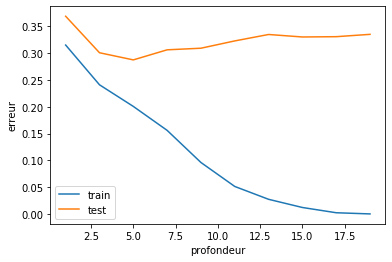

In [35]:
datax_app, datax_test, datay_app, datay_test = partage(datax, datay, 0.2)
compute_error(depths)

#### Partage en (0.5, 0.5) - 50% d'apprentissage: 

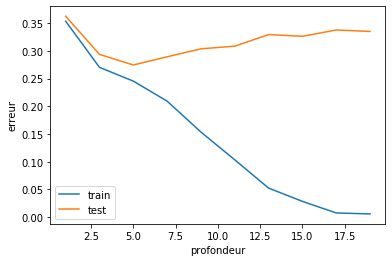

In [36]:
datax_app, datax_test, datay_app, datay_test = partage(datax, datay, 0.5)
compute_error(depths)

#### Partage en (0.8, 0.2) - 80% d'apprentissage: 

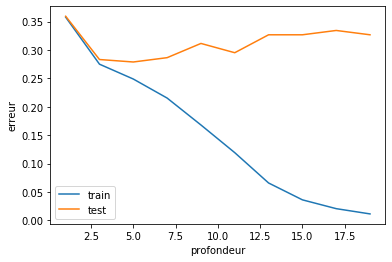

In [37]:
datax_app, datax_test, datay_app, datay_test = partage(datax, datay, 0.8)
compute_error(depths)

##### 1.8 Que remarquez vous quand il y a peu d’exemples d’apprentissage ? Comment progresse l’erreur ? De même quand il y a beaucoup d’exemples d’apprentissage. Est-ce le même comportement pour les deux erreurs ?

Plus il y a d'exemples d'apprentissage, plus il y a d'erreurs en apprentissage. 
Cependant, en augmentant la profondeur de l'arbre, cette difference disparait, car dans tous les cas, le sur-apprentissage signifie de moins en moins d'erreurs en apprentissage.

Quant à l'erreur en test, son évolution est logique. En effet, jusqu'à une certaine profondeur d'arbre, l'erreur en test diminue car on est encore dans un cadre d'apprentissage. Cependant à partir d'une certaine profondeur, l'erreur en test commence à augmenter car on est passé à du sur-apprentissage. 


##### 1.9 Vos résultats vous semblent ils fiables et stables ? Comment les améliorer ?

Nos résultats sont plus fiables qu'auparavant, mais pour les améliorer, il faudrait utiliser la validation croisée pour choisir les meilleurs paramètres pour notre modèle.

## Validation croisée : sélection de modèle

Essayons de trouver la meilleur valeur pour la profondeur max d'un arbre de décision.

In [19]:
# ------------------------
def crossval(X, Y, n_iterations, iteration):
    n = int(len(X)/n_iterations)
    Xtest = X[iteration*(n): (iteration+1)*(n)]
    Ytest = Y[iteration*n: (iteration+1)*n]

    Xapp= np.concatenate((X[0:iteration*n], X[(iteration+1)*n:len(X)]))
    Yapp = np.concatenate((Y[0:iteration*n], Y[(iteration+1)*n:len(Y)]))

    return Xapp, Yapp, Xtest, Ytest

# --------------------------
def crossval_strat(X, Y, n_iterations, iteration):
    Yuniques = np.unique(Y)
    nbClasses = len(Yuniques)
    Xs = []
    Ys = []
    Xapp = []
    Yapp = []
    Xtest = []
    Ytest = []

    for i in range(nbClasses):
        x = np.array([ X[i] for i in np.where((Y==Yuniques[i]))[0]])
        y = np.array([ Y[i] for i in np.where((Y==Yuniques[i]))[0]])

        Xapptmp, Yapptmp, Xtesttmp, Ytesttmp = crossval(x, y, n_iterations, iteration)
        Xapp.extend(Xapptmp)
        Yapp.extend(Yapptmp)
        Xtest.extend(Xtesttmp)
        Ytest.extend(Ytesttmp)
    return np.array(Xapp),np.array( Yapp), np.array(Xtest), np.array(Ytest)

# --------------------------

In [20]:
#on va tester sur 10 profondeurs (de 3 à 13)
depths = np.arange(3,13)
all_perf = []
for depth in depths:  
    print("Maximum depth = ", depth)
    perf_T = []
    #perf_A = []
    times = []
    niter=10
    for i in range(niter):

        Xapp,Yapp,Xtest,Ytest = crossval_strat(datax_app, datay_app, niter, i)
        dt = generate_dt(depth)
        tic= time.time()
        dt.fit(Xapp, Yapp)
        toc= time.time()
        times.append((toc -tic))
        #print("Iteration", i+1, f": Trained en {(toc-tic):.4} secondes")
        perf_T.append(dt.score(Xtest, Ytest))
        #perf_A.append(dt.score(Xapp, Yapp))

    print(f"\t{sum(times)/len(times):.4} secondes d'apprentissage.")
    #print("Perf A (apprentissage): ", ev.analyse_perfs(perf_A))
    print("\tPerformance : ", np.mean(perf_T), "\n")
    all_perf.append(np.mean(perf_T))

print("On obtient les meilleurs résultats avec une profondeur maximum de", depths[np.argmax(all_perf)])

Maximum depth =  3
	0.007794 secondes d'apprentissage.
	Performance :  0.7071038251366122 

Maximum depth =  4
	0.007853 secondes d'apprentissage.
	Performance :  0.716120218579235 

Maximum depth =  5
	0.005971 secondes d'apprentissage.
	Performance :  0.7169398907103826 

Maximum depth =  6
	0.009381 secondes d'apprentissage.
	Performance :  0.7193989071038251 

Maximum depth =  7
	0.02228 secondes d'apprentissage.
	Performance :  0.7101092896174863 

Maximum depth =  8
	0.009414 secondes d'apprentissage.
	Performance :  0.7180327868852459 

Maximum depth =  9
	0.01372 secondes d'apprentissage.
	Performance :  0.7169398907103826 

Maximum depth =  10
	0.0153 secondes d'apprentissage.
	Performance :  0.7153005464480875 

Maximum depth =  11
	0.0128 secondes d'apprentissage.
	Performance :  0.7076502732240437 

Maximum depth =  12
	0.01258 secondes d'apprentissage.
	Performance :  0.7008196721311475 

On obtient les meilleurs résultats avec une profondeur maximum de 6


Avec la validation croisée, on remarque que l'on obtient les meilleurs résultats avec une profondeur de 6.
A présent, on teste donc notre modèle sur les données de test avec la profondeur à 6

In [21]:
depth = 6
dt = generate_dt(depth)
dt.fit(datax_app, datay_app)
print("Performance en test avec prof = 6: " ,dt.score(datax_test, datay_test))


Performance en test avec prof = 6:  0.7113289760348583
